In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pickle
import os
import sys
import copy
# import PIL
# import PIL.Image
# import skimage
# from skimage import io
# from skimage.transform import rescale, resize, downscale_local_mean
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
from torchvision.datasets import CocoDetection
import torch.nn as nn
import time
list_pathstoadd = [
    "../../",
    "../../gpex/"
]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
from scarches.models.trvae.losses import mse, nb
from torch.distributions import Normal, kl_divergence
import gpex

Global seed set to 0


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#
list_idxoutputheads = [0,1,10,] #,3,4]
orig_num_outputheads = 1972
num_outputheads = len(list_idxoutputheads)

# Load Data

In [4]:
adata = sc.read('pbmc_tutorial.h5ad')
adata.X = adata.layers["counts"].copy()
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True
)

/home/akbar/anaconda3/envs/envpy39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/akbar/anaconda3/envs/envpy39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/akbar/anaconda3/envs/envpy39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/akbar/anaconda3/envs/envpy39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_ge

In [6]:
select_terms = adata.varm['I'].sum(0)>12

In [7]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [8]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [9]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [10]:
adata.X = adata.layers["counts"].copy()

# Make the main module (to be used by gpex)

In [11]:
#load the model ====
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


In [12]:
#modified classes ====
import scarches.models.expimap.modules
from scarches.models.expimap.modules import *
#class AkMaskedCondLayers(MaskedCondLayers):
def forward_MaskedCondLayers(self, x: torch.Tensor):
    '''
    Forward takes in a tensor of shape [N x D x 1 x 1], 
        and returns a tensor of shape [N x D' x 1 x 1]
    '''
    assert(len(list(x.size())) == 4)
    assert(x.size()[2] == 1)
    assert(x.size()[3] == 1)
    x = x[:,:,0,0]
    if self.n_cond == 0:
        expr, cond = x, None
    else:
        expr, cond = torch.split(x, [x.shape[1] - self.n_cond, self.n_cond], dim=1)

    if self.n_ext == 0:
        ext = None
    else:
        expr, ext = torch.split(expr, [expr.shape[1] - self.n_ext, self.n_ext], dim=1)

    if self.n_ext_m == 0:
        ext_m = None
    else:
        expr, ext_m = torch.split(expr, [expr.shape[1] - self.n_ext_m, self.n_ext_m], dim=1)

    out = self.expr_L(expr)
    if ext is not None:
        out = out + self.ext_L(ext)
    if ext_m is not None:
        out = out + self.ext_L_m(ext_m)
    if cond is not None:
        out = out + self.cond_L(cond)
    out = out.unsqueeze(-1).unsqueeze(-1) #[N x D' x 1 x 1] #ak
    
    #subsample output heads ===
    out = out[:, list_idxoutputheads, :, :] #ak
    
    return out

#class AkMaskedLinearDecoder(MaskedLinearDecoder):
def forward_MaskedLinearDecoder(self, z, batch=None):
    '''
    The forward function is modified to be compatible with the modified L0 module. 
    '''
    if batch is not None:
        batch = one_hot_encoder(batch, n_cls=self.n_cond)
        z_cat = torch.cat((z, batch), dim=-1)
        z_cat = z_cat.unsqueeze(-1).unsqueeze(-1) #ak
        dec_latent = self.L0(z_cat)
    else:
        z = z.unsqueeze(-1).unsqueeze(-1) #ak
        dec_latent = self.L0(z)
    
    if(len(list(dec_latent.size())) == 4):
        dec_latent = dec_latent[:,:,0,0] #[N x D] #ak
    
    #ak add additional dimensions if needed ===
    if(dec_latent.size()[1] != orig_num_outputheads):
        dec_latent = torch.cat(
          [dec_latent,\
           torch.zeros((dec_latent.size()[0], orig_num_outputheads-dec_latent.size()[1])).to(dec_latent.device)],
          1
        )
    
    recon_x = self.mean_decoder(dec_latent)
    return recon_x, dec_latent

In [13]:
intr_cvae.model.decoder.forward = \
    forward_MaskedLinearDecoder.__get__(
        intr_cvae.model.decoder,
        type(intr_cvae.model.decoder)
)
#forward_MaskedLinearDecoder

In [14]:
intr_cvae.model.decoder.L0.forward = \
    forward_MaskedCondLayers.__get__(
        intr_cvae.model.decoder.L0,
        type(intr_cvae.model.decoder.L0)
)

#forward_MaskedCondLayers

In [15]:
def akforward(self, x=None, batch=None, sizefactor=None, labeled=None):
    x_log = torch.log(1 + x)
    if self.recon_loss == 'mse':
        x_log = x

    z1_mean, z1_log_var = self.encoder(x_log, batch)
    z1 = self.sampling(z1_mean, z1_log_var)
    outputs = self.decoder(z1, batch)

    if self.recon_loss == "mse":
        recon_x, y1 = outputs
        recon_loss = mse(recon_x, x_log).sum(dim=-1).mean()
    elif self.recon_loss == "nb":
        if self.use_l_encoder and self.decoder_last_layer == "softmax":
            sizefactor = torch.exp(self.sampling(*self.l_encoder(x_log, batch))).flatten()
        dec_mean_gamma, y1 = outputs
        
        #ak ===
        if(sizefactor is None):
            sizefactor = torch.Tensor(list(x.size())[0] * [0]).to(x.device) #dummy value.
        #===== ak
        
        size_factor_view = sizefactor.unsqueeze(1).expand(dec_mean_gamma.size(0), dec_mean_gamma.size(1))
        if self.decoder_last_layer == "softmax":
            dec_mean = dec_mean_gamma * size_factor_view
        else:
            dec_mean = dec_mean_gamma
        dispersion = F.linear(one_hot_encoder(batch, self.n_conditions), self.theta)
        dispersion = torch.exp(dispersion)
        recon_loss = -nb(x=x, mu=dec_mean, theta=dispersion).sum(dim=-1).mean()

    z1_var = torch.exp(z1_log_var) + 1e-4
    kl_div = kl_divergence(
        Normal(z1_mean, torch.sqrt(z1_var)),
        Normal(torch.zeros_like(z1_mean), torch.ones_like(z1_var))
    ).sum(dim=1).mean()

    if self.use_hsic:
        if not self.hsic_one_vs_all:
            z_ann = z1[:, :-self.n_ext_decoder]
            z_ext = z1[:, -self.n_ext_decoder:]
            hsic_loss = hsic(z_ann, z_ext)
        else:
            hsic_loss = 0.
            sz = self.latent_dim + self.n_ext_encoder
            shift = self.latent_dim + self.n_ext_m_decoder
            for i in range(self.n_ext_decoder):
                sel_cols = torch.full((sz,), True, device=z1.device)
                sel_cols[shift + i] = False
                rest = z1[:, sel_cols]
                term = z1[:, ~sel_cols]
                hsic_loss = hsic_loss + hsic(term, rest)
    else:
        hsic_loss = torch.tensor(0.0, device=z1.device)

    return recon_loss, kl_div, hsic_loss

intr_cvae.model.forward = \
    akforward.__get__(
        intr_cvae.model,
        type(intr_cvae.model)
)

In [16]:
intr_cvae.model.load_state_dict(
    torch.load(
        "initial_intr_cvae_trained.pt/model_params.pt"
     ),
    strict = True
)

<All keys matched successfully>

In [17]:
#test the modified forward ===
n = 0
listset_batches = list(set(adata.obs['batch']))
idx_batch = listset_batches.index(list(adata.obs["batch"])[n])


intr_cvae.model(torch.Tensor(adata.X[0:2,:]), torch.Tensor(2*[0]))
print("intr_cvae.model.forward() was called.")

intr_cvae.model.forward() was called.


In [18]:
#load aksplitinfo ====
with open('aksplitinfo.pkl', 'rb') as akfile: 
    # Call load method to deserialze
    akcontent = pickle.load(akfile)
print(akcontent.keys())

dict_keys(['condenc_train', 'cond_train', 'np_Xtrain', 'condenc_test', 'cond_test', 'np_Xtest'])


# Make the GPEX-frendly Module

In [19]:
class VectoImg(nn.Module):
    def __init__(self):
        super(VectoImg, self).__init__()
    def forward(self, x):
        '''
        Convert the input of shape [N x D] to a tensor of shape [N x D x 1 x 1].
        '''
        return x.unsqueeze(-1).unsqueeze(-1)

class ImgtoVec(nn.Module):
    def __init__(self):
        super(ImgtoVec, self).__init__()
        
    def forward(self, x):
        '''
        Convert the input of shape [N x D x 1 x 1] to a tensor of shape [N x D].
        '''
        return x[:,:,0,0]

class SplitChanNormalize(nn.Module):
    def __init__(self, num_outputheads, dim_per_head):
        super(SplitChanNormalize, self).__init__()
        #grab args ===
        self.num_outputheads = num_outputheads
        self.dim_per_head = dim_per_head
        #make other internals ===
        list_dimrange = []
        for c in range(self.num_outputheads):
            list_dimrange.append(
                [c*dim_per_head , (c+1)*dim_per_head]
            )
        self.list_dimrange = list_dimrange
        
        
        
    def forward(self, x):
        list_toret = [
            torch.nn.functional.normalize(x[:, dimrng[0]:dimrng[1], 0, 0])*0.1
            for dimrng in self.list_dimrange
        ]
        toret = torch.cat(list_toret, 1).unsqueeze(-1).unsqueeze(-1)
        return toret

class MainModule(nn.Module):
    def __init__(self, adata, expimap_intr_cvae, dict_akcontent, device, batchsize=1000):
        super(MainModule, self).__init__()
        #grab args ====
        self.adata = adata
        self.expimap_intr_cvae = expimap_intr_cvae
        self.dict_akcontent = dict_akcontent
        self.device = device
        self.batchsize = batchsize
        #make other internals ======
        #unpack dict_akcontent==
        self.condenc_train = dict_akcontent["condenc_train"]
        self.cond_train = dict_akcontent["cond_train"]
        self.np_Xtrain = dict_akcontent["np_Xtrain"]
        self.condenc_test = dict_akcontent["condenc_test"]
        self.cond_test = dict_akcontent["cond_test"]
        self.np_Xtest = dict_akcontent["np_Xtest"]
        #TODO:change modulef1 
        self.module_f1 = torch.nn.Sequential(
            nn.Conv2d(286, 200, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(200, num_outputheads*20, kernel_size=1, stride=1, padding=0),
            SplitChanNormalize(
                num_outputheads = num_outputheads,
                dim_per_head = 20
            ),
            nn.LeakyReLU()
            
        )
        #recurring information ====
        self._setpartition_idx_recurring()
        self._idx_lastrecurringbatch = 0
    
    def _setpartition_idx_recurring(self):
        '''
        Partitions the recurring dataset indices, 
            and stores it in `self._list_recurringpartition`
        '''
        batchsize = self.batchsize
        list_idx_permuted = np.random.permutation(self.np_Xtrain.shape[0])
        N = self.np_Xtrain.shape[0]
        num_partitions = math.ceil(N/self.batchsize)
        list_partitions = []
        for j in range(num_partitions):
            idx_begin = j*batchsize
            idx_end = min((j+1)*batchsize, N)
            list_partitions.append(list_idx_permuted[idx_begin:idx_end])
        #check that list_partisions contains all indices ===
        list_temp = []
        for u in list_partitions:
            for v in u:
                list_temp.append(v)
        assert(set(list_temp) == set(list_idx_permuted))
        self._list_recurringpartition = list_partitions
        
    
    def func_get_modulef1(self):
        return self.module_f1
    
    def func_mainmodule_to_moduletobecomeGP(self, module_input):
        return module_input.expimap_intr_cvae.model.decoder.L0
        
    def func_feed_recurring_minibatch(self):
        #get the next batch ===
        self._idx_lastrecurringbatch += 1
        if(self._idx_lastrecurringbatch >= len(self._list_recurringpartition)):
            self._idx_lastrecurringbatch = 0
        listidx_recbatch = self._list_recurringpartition[self._idx_lastrecurringbatch]
        
        #set the last fed indices ==
        self._lastidx_recurring = listidx_recbatch
        
        #feed the mini-batch ===
        output = self.expimap_intr_cvae.model(
            torch.Tensor(self.np_Xtrain[listidx_recbatch, :]).to(self.device),
            torch.Tensor(np.array(self.cond_train)[listidx_recbatch].tolist()).to(self.device)
        )
        return output
    
    def func_feed_noise_minibatch(self):
        #randselect some instances ===
        listidx_noise = np.random.permutation(self.np_Xtrain.shape[0])[0:self.batchsize].tolist()
        np_x = self.np_Xtrain[listidx_noise, :]
        np_x_permuted = np_x[ np.random.permutation(np_x.shape[0]).tolist() ,  :]
        x = torch.Tensor(np_x)
        x_permuted = torch.Tensor(np_x_permuted)
        rand_w = torch.rand((list(x.size())[0])).float().unsqueeze(-1) #[N x 1]
        x_tofeed = rand_w*x + (1.0-rand_w)*x_permuted
        
        #feed the noise mini-batch ===
        output = self.expimap_intr_cvae.model(
            x_tofeed.to(self.device),
            torch.Tensor(list(x_tofeed.size())[0] * [0]).to(self.device)
        )
        return output
        
    def func_feed_nonrecurring_minibatch(self):
        return self.func_feed_recurring_minibatch() #TODO:check
    
    def func_feed_test_minibatch(self):
        batchsize_test = 10
        listidx_selected = np.random.permutation(
            self.np_Xtest.shape[0])[0:batchsize_test].tolist()#batchsize_test
        #feed the mini-batch ===
        output = self.expimap_intr_cvae.model(
            torch.Tensor(self.np_Xtest[listidx_selected, :]).to(self.device),
            torch.Tensor(np.array(self.cond_train)[listidx_selected].tolist()).to(self.device)
        )
        return output
    
    def func_get_indices_lastrecurringinstances(self):
        return self._lastidx_recurring.tolist()


In [20]:
intr_cvae.model.to(device)
module_main = MainModule(adata, intr_cvae, akcontent, device)
module_main.to(device)

MainModule(
  (module_f1): Sequential(
    (0): Conv2d(286, 200, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(200, 60, kernel_size=(1, 1), stride=(1, 1))
    (3): SplitChanNormalize()
    (4): LeakyReLU(negative_slope=0.01)
  )
)

# Make the GPEX module

In [21]:
flag_efficient = True
flag_detachcovpvn = True
flag_controlvariate = True
flag_setcovtoOne = False
int_mode_controlvariate = 2
countupdateU_afterupdateGP = 1
flag_train_memefficient, memefficeint_heads_in_compgraph = False, None

gpexmodule = gpex.GPEXModule(
    module_rawmodule = module_main,
    size_recurringdataset = module_main.np_Xtrain.shape[0],
    device = device,
    func_mainmodule_to_moduletobecomeGP = module_main.func_mainmodule_to_moduletobecomeGP, 
    func_feed_noise_minibatch = module_main.func_feed_noise_minibatch,
    func_feed_inducing_minibatch = module_main.func_feed_recurring_minibatch,
    func_feed_nonrecurring_minibatch = module_main.func_feed_nonrecurring_minibatch,
    func_feed_test_minibatch = module_main.func_feed_test_minibatch,
    func_get_indices_lastrecurringinstances = module_main.func_get_indices_lastrecurringinstances,
    func_get_modulef1 = module_main.func_get_modulef1,
    flag_efficient = flag_efficient,
    flag_detachcovpvn = flag_detachcovpvn,
    flag_controlvariate = flag_controlvariate,
    flag_setcovtoOne = flag_setcovtoOne,
    int_mode_controlvariate = int_mode_controlvariate,
    flag_train_memefficient = flag_train_memefficient,
    memefficeint_heads_in_compgraph = memefficeint_heads_in_compgraph
)
gpexmodule.sigma2_GP = 1.0 #TODO:check
gpexmodule.train()
gpexmodule.to(device)
print("gpmodel was created on {}".format(device))

Controlvariate mode is set to 2
x.shape = torch.Size([1000, 286, 1, 1])
    Dv was set to 3
gpmodel was created on cuda:0


In [22]:
#load the demo checkpoint ===
gpexmodule.load_state_dict(
        torch.load(
            "NonGit/checkpoint_gpex.pt"
        ),
        strict = True
)
print("Gpex checkpoint was loaded.")

Gpex checkpoint was loaded.


/home/akbar/OnGit/CVPR_GPEX/gpex_cvpr2023/PaperResults/scArches/../../gpex/gpexmodule.py:182: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2524.)
  landa_1toD, Qd= torch.symeig(XTX, eigenvectors=True) #u, s, v = torch.svd(L)
/tmp/ipykernel_14871/2229861054.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call gr

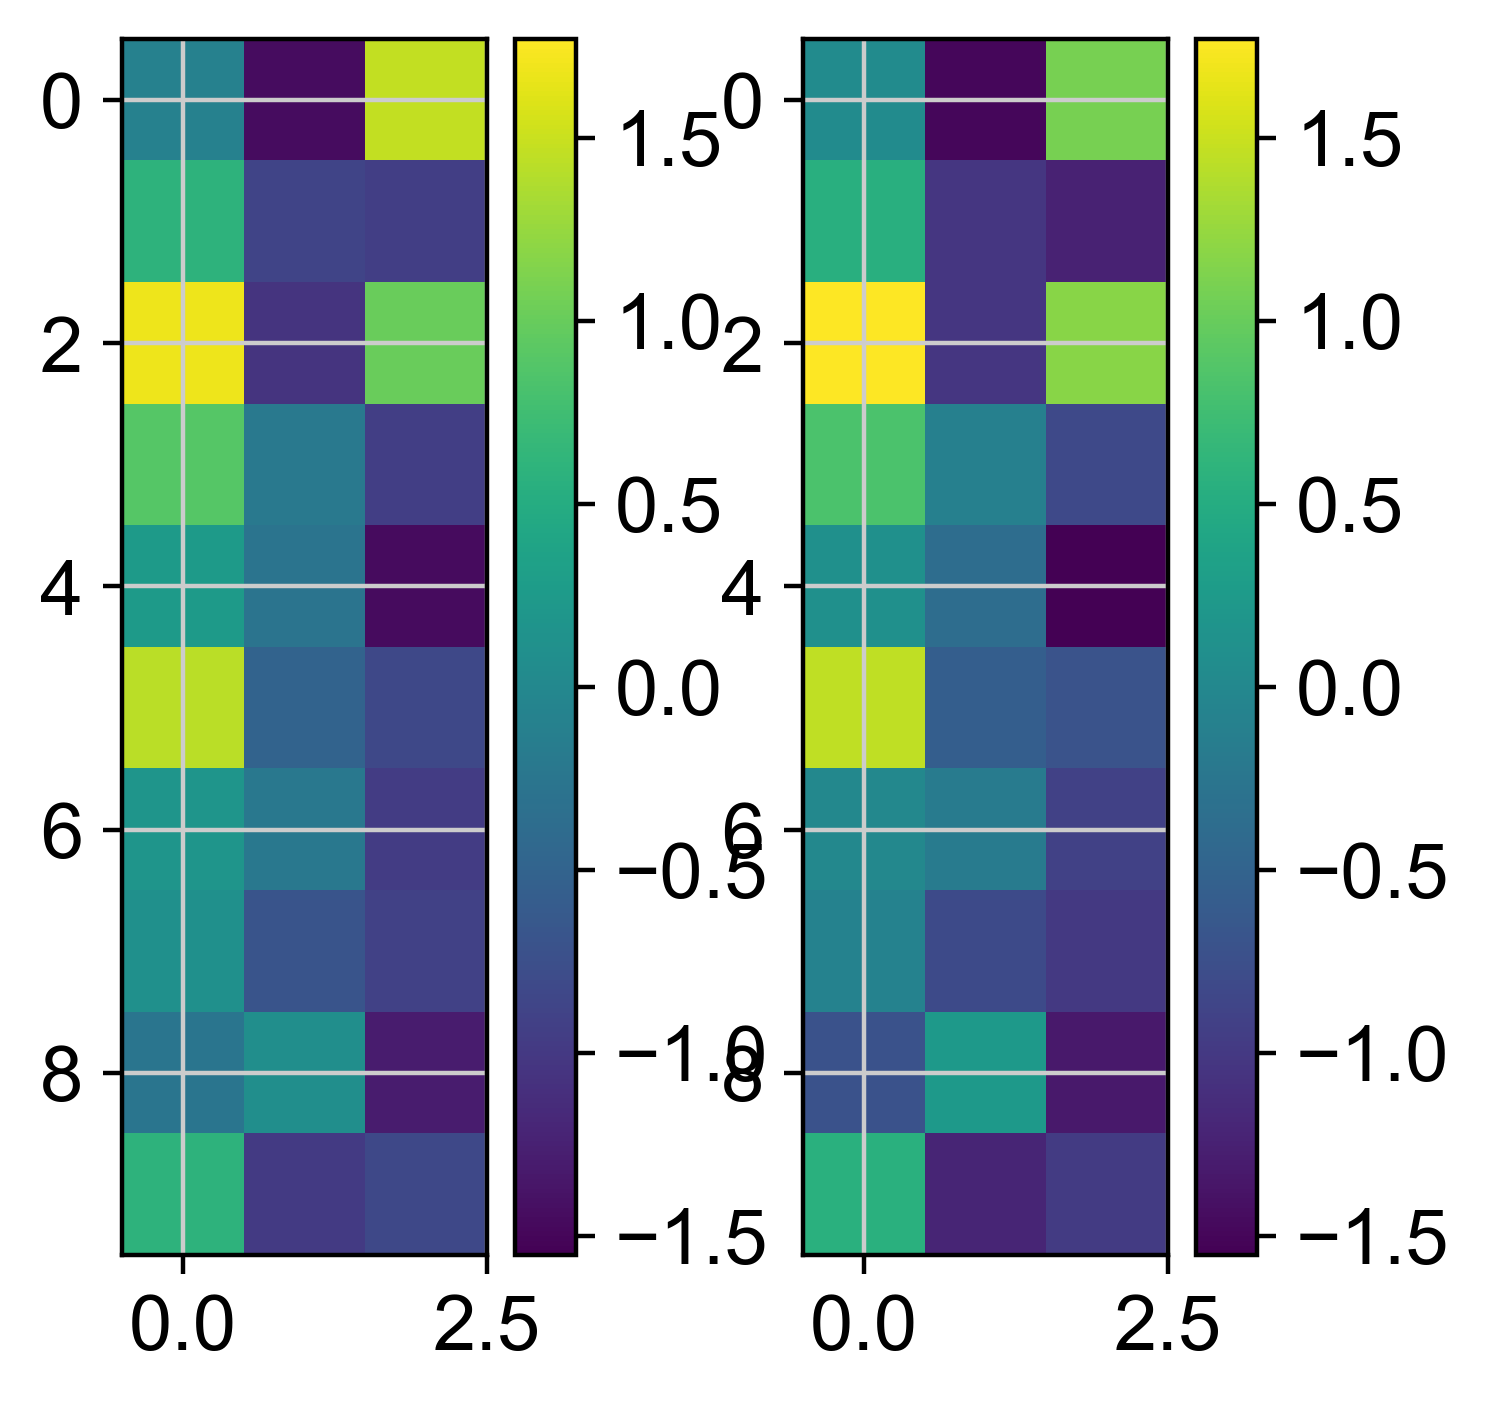

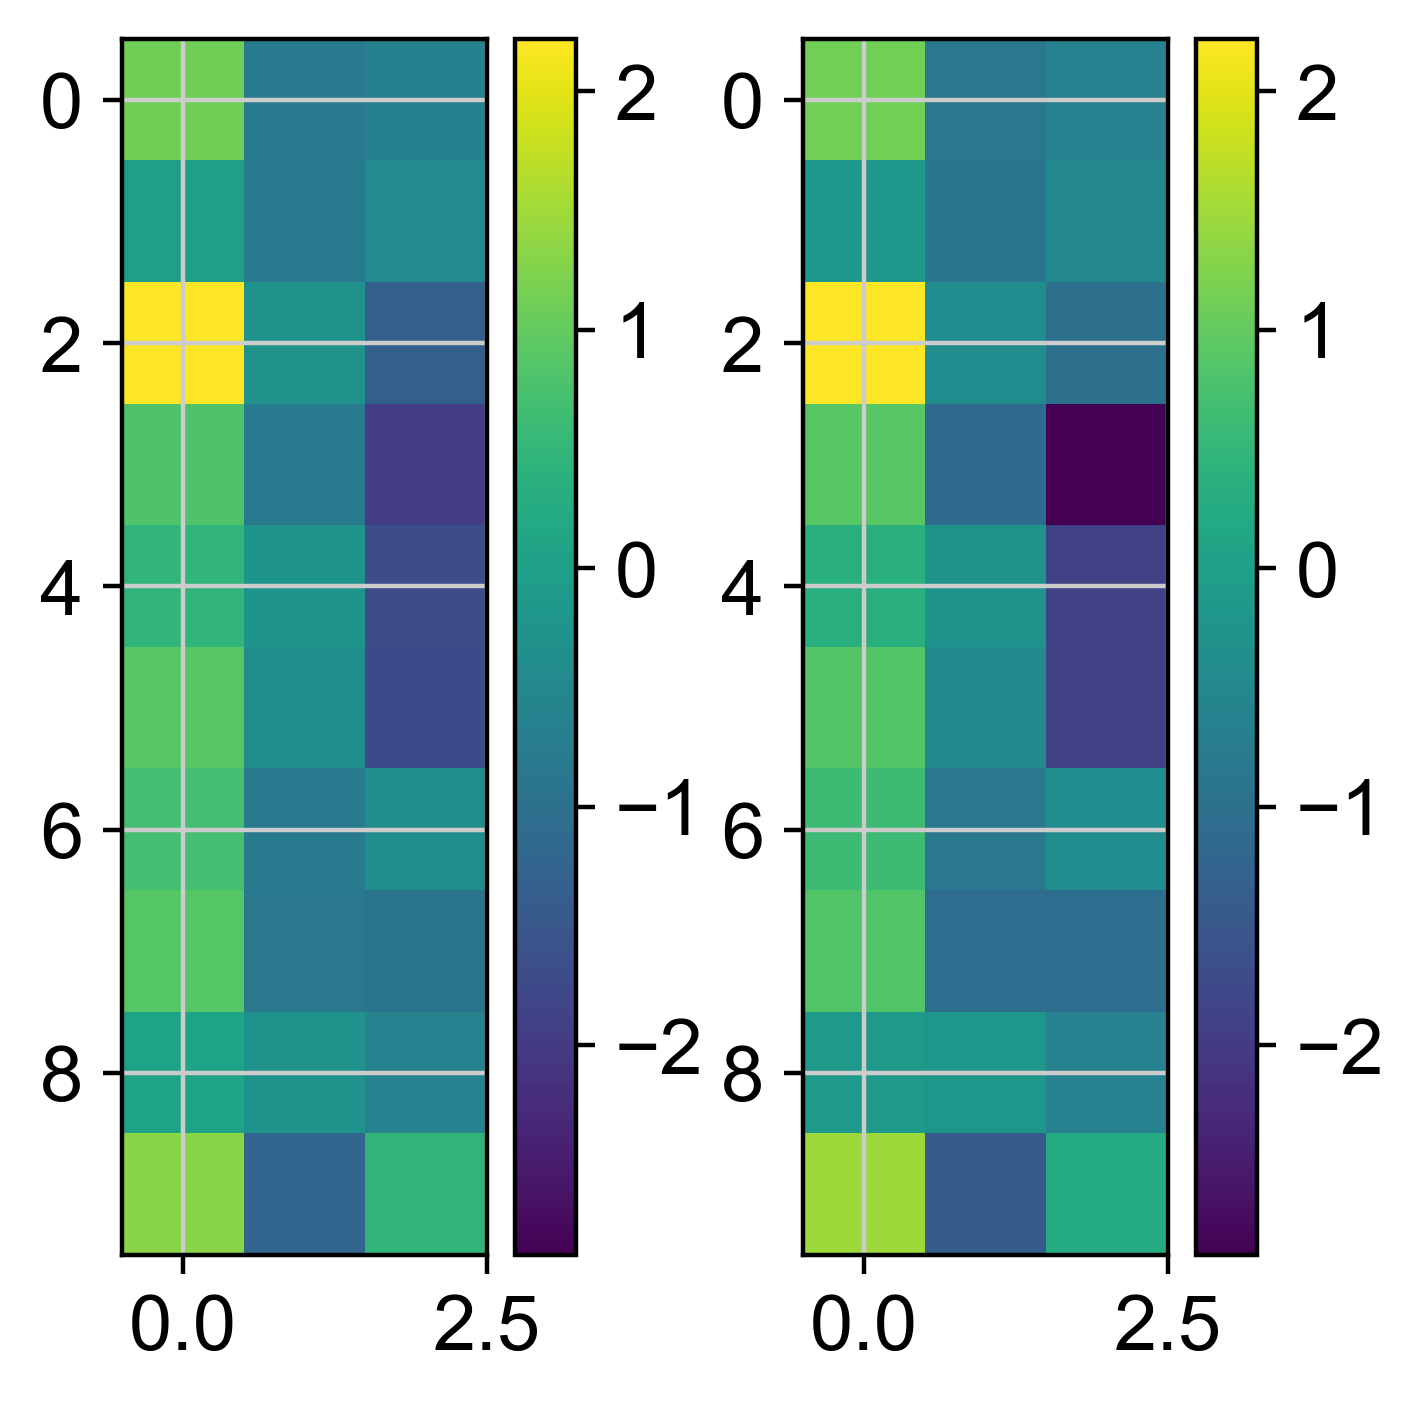

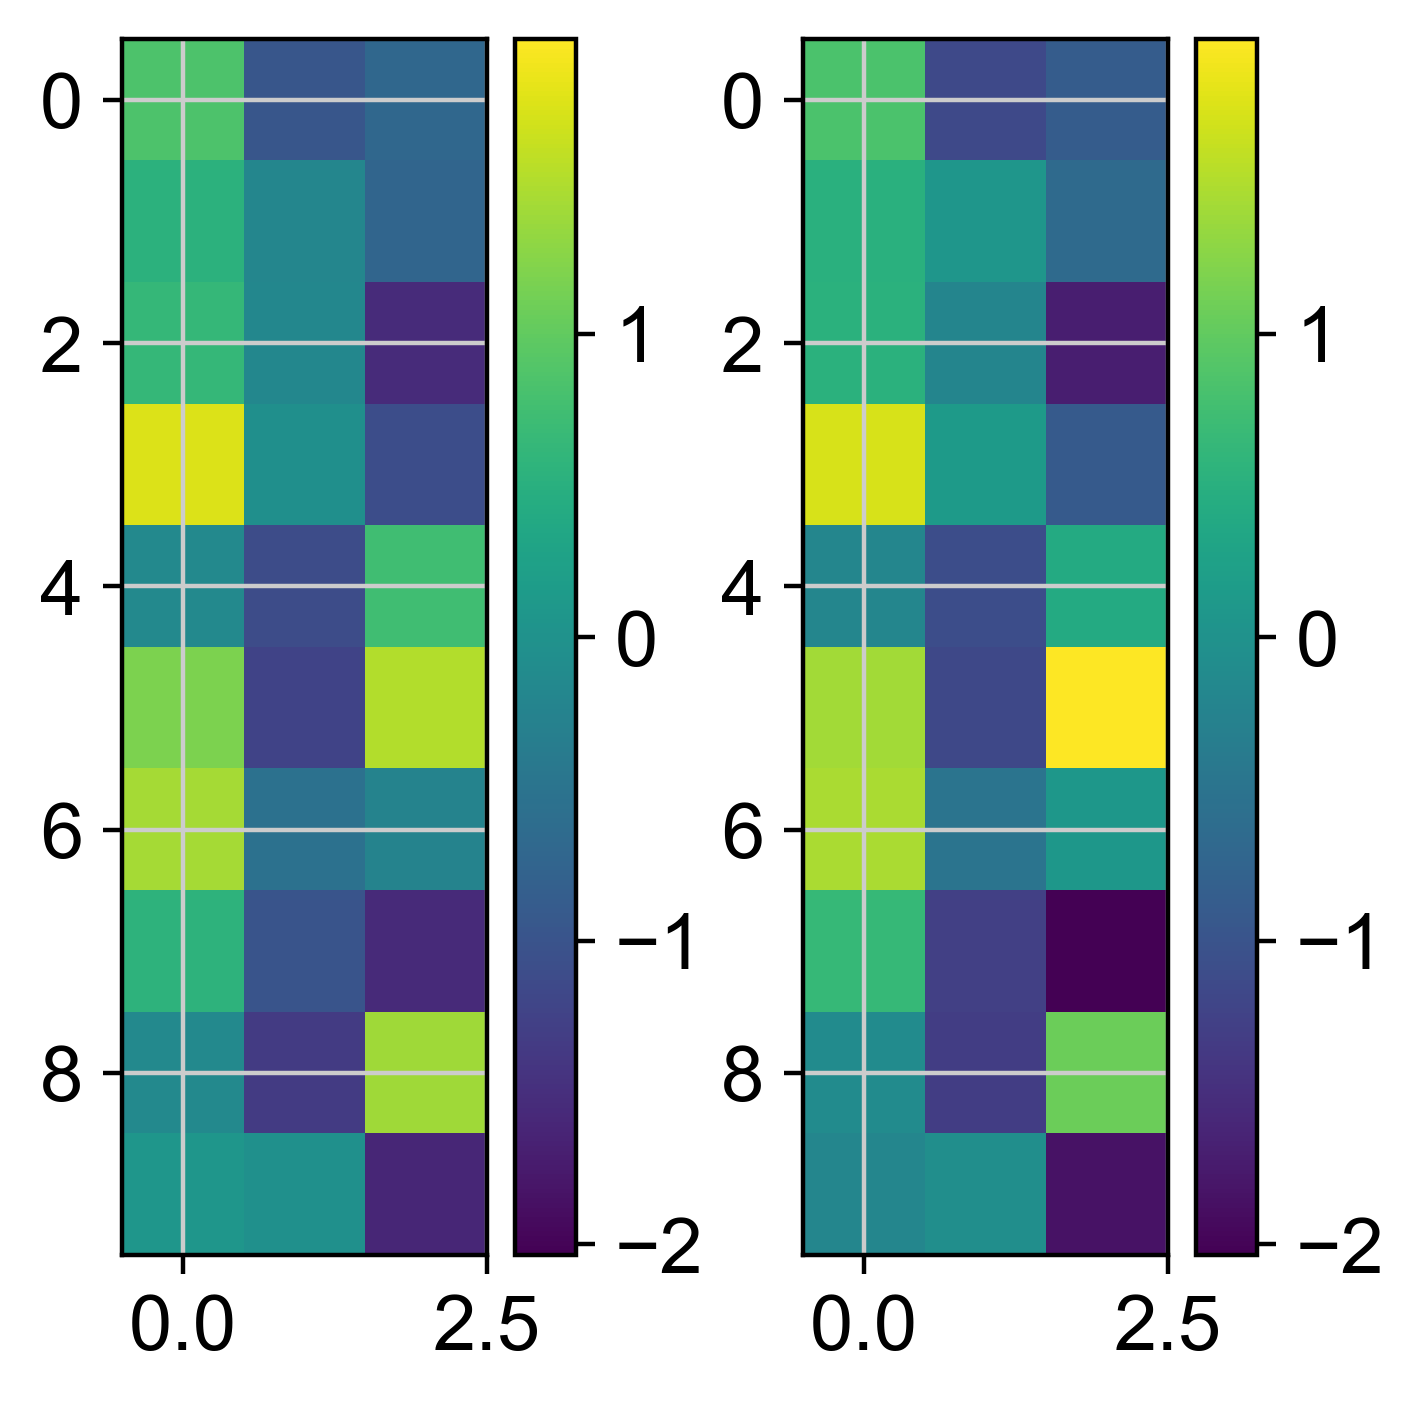

In [23]:
output_gp_ann = gpexmodule.checkequal_f1path_gpath_ontest(3)
for uv in output_gp_ann:
    u, v = uv
    min_uv = min(np.min(u), np.min(v))
    max_uv = max(np.max(u), np.max(v))
    plt.subplot(1,2,1)
    plt.imshow(u, vmin=min_uv, vmax=max_uv); plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(v, vmin=min_uv, vmax=max_uv); plt.colorbar()
    plt.show()

In [24]:
np_all_gpann = []
for t in range(module_main.np_Xtest.shape[0]):
    if((t%100) == 0):
        print(t)
    np_curr_gp, np_curr_ann = gpexmodule.checkequal_f1path_gpath_ontest(1)[0]
    np_all_gpann.append(
        np.concatenate([np_curr_gp[0,:].flatten(), np_curr_ann[0,:].flatten()])
    )
np_all_gpann = np.stack(np_all_gpann)
print(np_all_gpann.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
(3246, 6)


In [25]:
from scipy import stats
list_allcorrel = []
for k in range(np_all_gpann.shape[1]//2):
    correl_k = stats.pearsonr(
        np_all_gpann[:, k],
        np_all_gpann[:, k+np_all_gpann.shape[1]//2]
    )[0]
    list_allcorrel.append(correl_k)
print(list_allcorrel)

[0.9812777892951323, 0.940304310135712, 0.9728619066863823]


In [26]:
list_allcorrel = []
xxx = 10
plt.figure(figsize=[50,10])
for k in range(np_all_gpann.shape[1]//2):
    plt.subplot(1,np_all_gpann.shape[1]//2, k+1)
    correl_k = stats.pearsonr(
        np_all_gpann[:, k],
        np_all_gpann[:, k+np_all_gpann.shape[1]//2]
    )[0]
    list_allcorrel.append(correl_k)
    plt.scatter(
        np_all_gpann[:, k],
        np_all_gpann[:, k+np_all_gpann.shape[1]//2]
    )
    #plt.title("correl {}".format(correl_k))
print(list_allcorrel)

[0.9812777892951323, 0.940304310135712, 0.9728619066863823]
